# Part 1: Explore Dataset

### Import Libraries

In [28]:
import os, random
import shutil

import matplotlib
import numpy as np
import torch
import PIL
import torchvision
import pandas as pd
import ipywidgets as widgets
from tqdm.notebook import tqdm

Check version.

In [2]:
print("torch version:", torch.__version__)
print("torchvision version:", torchvision.__version__)
print("PIL version:", PIL.__version__)
print("numpy version:", np.__version__)
print("matplotlib version:", matplotlib.__version__)
!python --version

torch version: 2.5.1
torchvision version: 0.20.1
PIL version: 10.4.0
numpy version: 1.26.4
matplotlib version: 3.8.4
Python 3.12.3


### Exploring the Dataset

The data for this project is from [Kaggle](https://www.kaggle.com/datasets/nirmalsankalana/crop-pest-and-disease-detection) composed of crop pests/disease datasets sourced from local farms in Ghana. It consists four crops: cashew, cassava, maize and tomato.

In [3]:
data_dir = os.path.join("../data", "plant disease")
folders = os.listdir(data_dir)
crops = list(set([fold_name.split()[0] for fold_name in folders]))
print("crops:", crops)

crops: ['Tomato', 'Cassava', 'Cashew', 'Maize']


Now, let's move folders of the same crops into one folder with name of the crop.

In [4]:
crops

['Tomato', 'Cassava', 'Cashew', 'Maize']

In [5]:
def move_fold(crop):
    for fold_name in folders:
        if crop in fold_name:
            src_fold = os.path.join(data_dir, fold_name)
            dest_fold = os.path.join(data_dir, crop, fold_name)
            shutil.move(src_fold, dest_fold)
    print(crop, "done!")

In [6]:
for crop in crops:
    move_fold(crop)

Tomato done!
Cassava done!
Cashew done!
Maize done!


Now let's examine each crop distribution among its classes.

In [9]:
def list_classes(crop):
    crop_path = os.path.join(data_dir, crop)
    classes = os.listdir(crop_path)
    class_counts = []
    for clss in classes:
        class_path = os.path.join(data_dir, crop, clss)
        class_counts.append(len(os.listdir(class_path)))
    class_dist = pd.Series(class_counts, index= classes)
    
    return class_dist

Tomato healthy                470
Tomato leaf blight           1315
Tomato leaf curl              518
Tomato septoria leaf spot    2743
Tomato verticulium wilt       759
dtype: int64


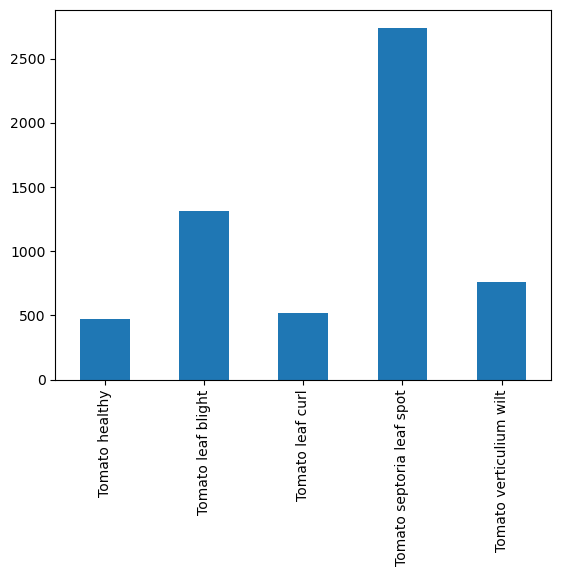

In [13]:
tom_dist = list_classes(crops[0])
print(tom_dist)
tom_dist.plot(kind= "bar");

In [33]:
col_name_widget = widgets.Dropdown(
                options=crops,
                value= crops[0],
                description='Crop:',
                disabled=False,
            )

def feat_analysis(col_name):
    class_dist = list_classes(col_name)
    print(class_dist)
    class_dist.plot(kind= "bar");

widgets.interact(feat_analysis, col_name = col_name_widget);

interactive(children=(Dropdown(description='Crop:', options=('Tomato', 'Cassava', 'Cashew', 'Maize'), value='T…

As can be seen above, the data is unbalanced as there are more dominant classes and others are few in number. If these data are used in training a model, the model will be affected by the class which has the most number.

In [20]:
for crop in crops:
    crop_counts = list_classes(crop)
    print(f"{crop} data: {crop_counts.sum()}")

Tomato data: 5805
Cassava data: 7508
Cashew data: 6549
Maize data: 5358


Since there are more number of images in `cassava`, let's pick this folder for this project. As it was said above, the data is unbalanced, hence we need to preprocess it before we proceed to developing a model. The technique we use here is `undersampling`, as the data are images. First, let's look few examples of each classes of cassava data. Then we will do undersampling.

In [30]:
crops

['Tomato', 'Cassava', 'Cashew', 'Maize']

In [34]:
cass_data_dir = os.path.join(data_dir, 'Cassava')
cass_classes = os.listdir(cass_data_dir)
cass_classes

['Cassava bacterial blight',
 'Cassava brown spot',
 'Cassava green mite',
 'Cassava healthy',
 'Cassava mosaic']

In [37]:
import matplotlib.pyplot as plt


def sam_images(cass_class):
    class_dir = os.path.join(cass_data_dir, cass_class)
    images = os.listdir(class_dir)

    samples = random.sample(images, 4)

    plt.figure(figsize= (20, 20))
    for i in range(4):
        img = PIL.Image.open(os.path.join(class_dir, samples[i]))
        plt.subplot(1, 4, i + 1)
        plt.imshow(img)
        plt.axis("off")

Cassava bacterial blight


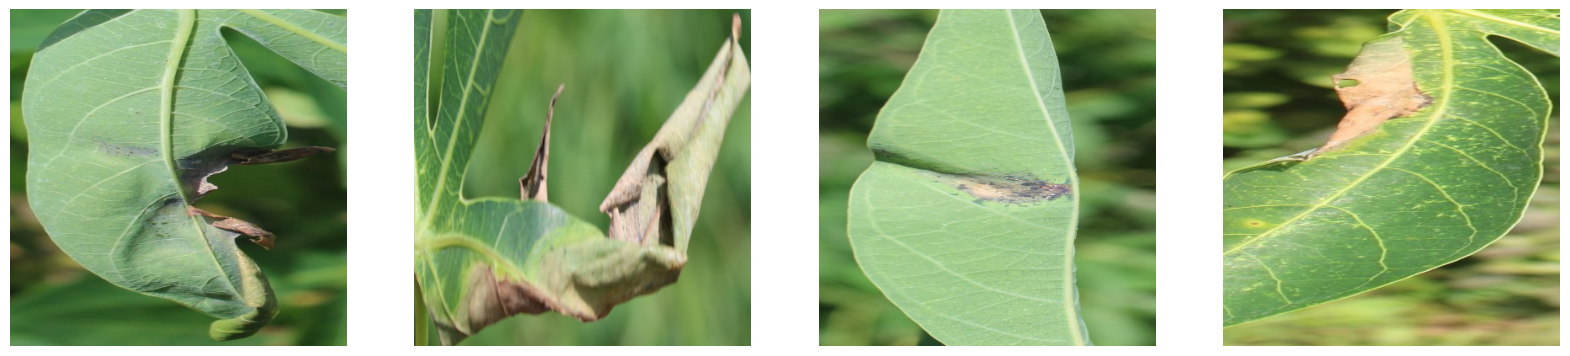

In [40]:
print(cass_classes[0])
sam_images(cass_class= cass_classes[0])

In [42]:
col_name_widget = widgets.Dropdown(
                options=cass_classes,
                value= cass_classes[0],
                description='Classes:',
                disabled=False,
            )

def feat_analysis(col_name):
    sam_images(col_name)

widgets.interact(feat_analysis, col_name = col_name_widget);

interactive(children=(Dropdown(description='Classes:', options=('Cassava bacterial blight', 'Cassava brown spo…

Now, it's time to undersample the data.

In [57]:
def data_undersampling(crop, count= None):
    """
    Undersample the data to have a uniform distribution among the classes.

    Parameters
    ----------
    crop : str
        Name of the crop we want to undersample the data.
    count : int, optional
        Number of samples per class. If None, use the minimum class size.
    """
    src_dir = os.path.join(data_dir, crop)
    classes = os.listdir(src_dir)
    class_images = {
        class_name: os.listdir(os.path.join(src_dir, class_name)) for class_name in classes
    }

    if count is None:
        count = min(len(imgs) for imgs in class_images.values())
    
    dst_dir = os.path.join(src_dir, "undersampled")

    for class_name, imgs in class_images.items():
        print("Copying images from:", class_name)
        class_dst_dir = os.path.join(dst_dir, class_name)
        if not os.path.exists(class_dst_dir):
            os.makedirs(class_dst_dir)
        
        sampled_imgs = random.sample(imgs, min(len(imgs), count))

        for img_name in tqdm(sampled_imgs):
            src_path = os.path.join(src_dir, class_name, img_name)
            dst_path = os.path.join(class_dst_dir, img_name)
            shutil.copy2(src_path, dst_path)

    print(f"Unersampling '{crop}' data is done.")

In [59]:
data_undersampling("Cassava")

Copying images from: Cassava bacterial blight


  0%|          | 0/1015 [00:00<?, ?it/s]

Copying images from: Cassava brown spot


  0%|          | 0/1015 [00:00<?, ?it/s]

Copying images from: Cassava green mite


  0%|          | 0/1015 [00:00<?, ?it/s]

Copying images from: Cassava healthy


  0%|          | 0/1015 [00:00<?, ?it/s]

Copying images from: Cassava mosaic


  0%|          | 0/1015 [00:00<?, ?it/s]

Unersampling 'Cassava' data is done.


Now each class has equal number of instances, 1015 images in each folder. Let's check it.

Cassava bacterial blight    1015
Cassava brown spot          1015
Cassava green mite          1015
Cassava healthy             1015
Cassava mosaic              1015
dtype: int64


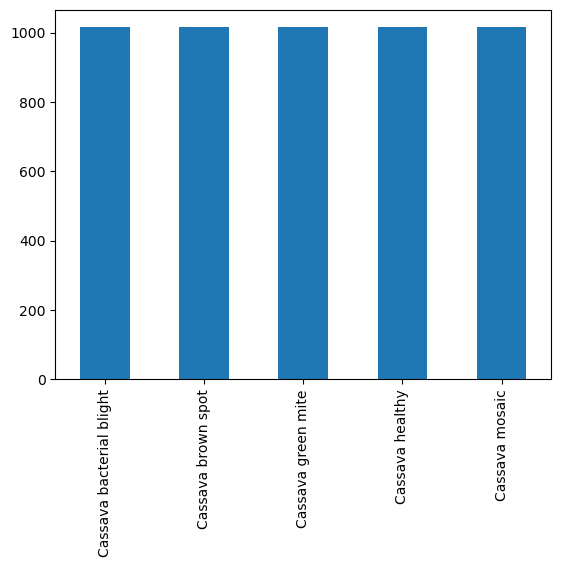

In [63]:
undersampled_path = "../data/plant disease/Cassava/undersampled"
classes = os.listdir(undersampled_path)

class_counts = []
for clss in classes:
    class_path = os.path.join(undersampled_path, clss)
    class_counts.append(len(os.listdir(class_path)))
class_dist = pd.Series(class_counts, index= classes)
print(class_dist)
class_dist.plot(kind= "bar");

Now the bar plot shows that the data is evenly distributed among the classes.

### Conclusion
In this nootebook, 
* the data from Kaggle is examined for different crops,
* sample images from each crop is shown,
* data distribution of each crop under their classes is tested and found that data is unbalanced,
* undersampling is done on the unbalanced data.

In the next notebook, based on the undersampled data, multiclass classification will be done using CNN.